# Imports

In [1]:
import matplotlib
from google.colab import runtime

# Por defecto tiene matplotlib: 3.2.2
print('matplotlib: {}'.format(matplotlib.__version__))

if matplotlib.__version__ == '3.2.2':
    # Se necesita la versión 3.5.1 que soporta float16 para pintar kanji
    !pip install -U matplotlib

    print('Stopping RUNTIME! Please run again.')
    quit()
    # https://twitter.com/GoogleColab/status/1569389018311426051

matplotlib: 3.7.0


In [2]:
# track time of each cell
!pip install ipython-autotime
%load_ext autotime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
time: 423 µs (started: 2023-02-22 01:28:00 +00:00)


In [3]:
from pprint import pprint

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow, subplots, show
import PIL as pil
import skimage.transform
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    classification_report,
    confusion_matrix
)
from tensorflow import keras
from keras.layers import (
    Conv2D, MaxPool2D, Flatten, 
    Dense, Dropout, Input, Concatenate, 
    GlobalAveragePooling2D
)
from keras.models import Model
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from google.colab import drive

time: 3.16 s (started: 2023-02-22 01:28:00 +00:00)


In [4]:
CHANNEL = 1
DATA_REPR = 'float32' # Antes era 'uint8'
NUM_CLASSES = 2965
ETL_DATASET = 'etl_9G'
DNN_NAME = 'ResNet50'

USE_DATA_AUG = 'sin_DA' # o también con_DA
TYPE_IMG = 'inverted'

TFM_PATH = '/content/gdrive/MyDrive/Master_IA/TFM/'
ROOT_PATH = TFM_PATH + 'datasets/'+ ETL_DATASET +'/uint32/imgs_{}/splits/'+ TYPE_IMG +'_otsu/'

print(ROOT_PATH)
print('versión Keras:', keras.__version__)
print()

/content/gdrive/MyDrive/Master_IA/TFM/datasets/etl_9G/uint32/imgs_{}/splits/inverted_otsu/
versión Keras: 2.11.0

time: 1.21 ms (started: 2023-02-22 01:28:04 +00:00)


In [5]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
time: 3.4 s (started: 2023-02-22 01:28:04 +00:00)


# Funciones

In [6]:
def load_images_for_training(DATA_REPR, PATH, TYPE_IMG):
    '''
    Load images for training and validation with their labels

    Args:

    - DATA_REPR: Representation of numpy data. Ex: uint8, float32
    - PATH: Path in Google Drive where imgs and labels are stored
    - TYPE_IMG = regular o inverted

    Output:
    - np arrays for training and validation images
    '''
    if TYPE_IMG == 'regular':
        train_name_img = 'train_imgs_9G.npz'
        train_name_labels = 'train_labels_9G.npz'
        val_name_img = 'val_imgs_9G.npz'
        val_name_labels = 'val_labels_9G.npz'
    elif TYPE_IMG == 'inverted':
        train_name_img = 'train_inv_imgs_9G.npz'
        train_name_labels = 'train_inv_labels_9G.npz'
        val_name_img = 'val_inv_imgs_9G.npz'
        val_name_labels = 'val_inv_labels_9G.npz'

    train_images = np.load(PATH+train_name_img)['arr_0']
    train_labels = np.load(PATH+train_name_labels)['arr_0'].astype(DATA_REPR)

    val_images = np.load(PATH+val_name_img)['arr_0']
    val_labels = np.load(PATH+val_name_labels)['arr_0'].astype(DATA_REPR)

    return train_images, train_labels, val_images, val_labels


def load_test_images(DATA_REPR, PATH, TYPE_IMG):
    '''
    Load images for training and validation with their labels

    Args:

    - DATA_REPR: Representation of numpy data. Ex: uint8, float32
    - PATH: Path in Google Drive where imgs and labels are stored
    - TYPE_IMG = regular o inverted

    Output:
    - np arrays for testing images
    '''

    if TYPE_IMG == 'regular':
        test_name_img = 'test_imgs_9G.npz'
        test_name_labels = 'test_labels_9G.npz'
    elif TYPE_IMG == 'inverted':
        test_name_img = 'test_inv_imgs_9G.npz'
        test_name_labels = 'test_inv_labels_9G.npz'

    test_images = np.load(PATH+test_name_img)['arr_0']
    test_labels = np.load(PATH+test_name_labels)['arr_0'].astype(DATA_REPR)

    return test_images, test_labels


def create_custom_model(NUM_CLASSES, WIDTH_SHAPE, HEIGHT_SHAPE, CHANNEL):
    '''Crea un modelo de Deep Learning
    '''
    image_input = Input(shape=(WIDTH_SHAPE, HEIGHT_SHAPE, CHANNEL))
    img_conc = Concatenate()([image_input, image_input, image_input])

    m_Resnet50_9G = keras.applications.ResNet50(
        include_top=False,
        input_tensor=img_conc,
        weights='imagenet',
    )

    last_layer = m_Resnet50_9G.layers[-1].output
    x = GlobalAveragePooling2D()(last_layer)
    out = Dense(NUM_CLASSES, activation='softmax', name='predictions')(x)
    custom_model = Model(image_input, out)

    # freeze all the layers except the 2 newly added layers
    for layer in custom_model.layers[:-2]:
        layer.trainable = False

    return custom_model


def train_model(custom_model, train_images, train_labels, val_images, val_labels):

    callback = EarlyStopping(
        monitor='val_sparse_categorical_accuracy',
        patience=5,
        verbose=1
    )

    custom_model.compile(
        loss="sparse_categorical_crossentropy",
        optimizer=Adam(learning_rate=0.0001),
        metrics=["sparse_categorical_accuracy"]
    )

    history = custom_model.fit(
        train_images,
        train_labels,
        validation_data=(val_images, val_labels),
        epochs= 50, # en 2022 usé 20 epochs
        callbacks = [callback],
        # verbose = 1,
        # batch_size=32
    )

    print('--- Iterations ended ---')
    print()
    print()

    return history


def show_metrics(custom_model, test_images, test_labels):
    test_loss, test_accuracy = custom_model.evaluate(test_images, test_labels)
    y_pred = np.argmax(custom_model.predict(test_images), axis=1)

    print("*********************************************************************************************************************************")
    print()
    print("- Test Accuracy:", test_accuracy)
    print("- Test Loss:", test_loss)
    print("- time: ")
    print("- F1 score:", f1_score(test_labels, y_pred, average='weighted'))
    print("- Precision score:", precision_score(test_labels, y_pred, average='weighted'))
    print("- Recall: ", recall_score(test_labels, y_pred, average='weighted'))
    print("- Epoch: ")
    print("*********************************************************************************************************************************")


def plot_loss(history):
    pd.DataFrame(history.history).plot(figsize=(7,5))
    plt.grid(True)
    plt.gca().set_ylim(0,2) # usualmente 0,5
    plt.show()


def show_history(history):
    #-----------------------------------------------------------
    # Recuperar una lista de resultados de la lista de datos de los conjuntos de entrenamiento y pruebas para cada epoch de entrenamiento
    #-----------------------------------------------------------

    acc = history.history['sparse_categorical_accuracy']
    val_acc = history.history['val_sparse_categorical_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    #------------------------------------------------
    # Imprimir la precisión del entrenamiento y validación por epoch
    #------------------------------------------------
    plt.plot(epochs, acc, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Precisión de entrenamiento y validación')
    plt.legend()
    plt.grid()
    plt.figure()

    #------------------------------------------------
    # Imprimir la perdida de entrenamiento y validación por epoch
    #------------------------------------------------
    plt.plot(epochs, loss, 'bo', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Validation Loss')
    plt.title('Perdida de entrenamiento y validación')
    plt.legend()
    plt.grid()
    plt.show()


def save_model(SIZE, TFM_PATH, custom_model, TYPE_IMG, USE_DATA_AUG, DNN_NAME):
    '''Guardar el modelo en disco duro.
    Debe especificarse la ruta porque por defecto la guarda
    en el la memoria de la misma instancia de Google Colab.
    
    Args:
        - SIZE: 64, 96, 112 ó 127
        - TFM_PATH = Ruta en drive a la carpeta del TFM
        - custom_model = Modelo de Deep Learning
        - TYPE_IMG= regular o inverted
        - USE_DATA_AUG = sin_DA o con_DA
        - DNN_NAME = Deep Neural Network's name like ResNet50 or DenseNet121
    '''
    MODEL_NAME = f'model_{DNN_NAME.lower()}_etl9_imgs{SIZE}_'\
                + TYPE_IMG +'__OTSU.h5'

    WEIGHTS_PATH = TFM_PATH + 'notebooks/arqs_2023/' \
                + DNN_NAME + f'/weights_{DNN_NAME.lower()}/' \
                + USE_DATA_AUG +'/'+ TYPE_IMG +'/' + MODEL_NAME

    custom_model.save(WEIGHTS_PATH)
    print(f'------ Model Saved in {WEIGHTS_PATH}')


time: 6.97 ms (started: 2023-02-22 01:28:07 +00:00)


# Imgs 64x64

- Test Accuracy: 0.28483980894088745
- Test Loss: 4.237070560455322
- time: 2h 11min 17s
- F1 score: 0.2759820600399253
- Precision score: 0.33263834336301396
- Recall:  0.2848397976391231
- Epoch: 50/50


## Cargar la imágenes

In [8]:
SIZE = 64  # integer number. Ex: 64, 96, 112 or 127
WIDTH_SHAPE = SIZE
HEIGHT_SHAPE = SIZE
PATH = ROOT_PATH.format(SIZE)

print(PATH)

/content/gdrive/MyDrive/Master_IA/TFM/datasets/etl_9G/uint32/imgs_64/splits/inverted_otsu/
time: 1.08 ms (started: 2023-02-21 18:13:41 +00:00)


In [9]:
train_images, train_labels, val_images, val_labels = load_images_for_training(DATA_REPR, PATH, TYPE_IMG)

time: 11.3 s (started: 2023-02-21 18:13:42 +00:00)


In [10]:
print('- train images:', train_images.shape, 'and labels:', train_labels.shape)
print()
print('- val images:', val_images.shape, 'and labels:', val_labels.shape)
print()
print()

- train images: (444750, 64, 64, 1) and labels: (444750,)

- val images: (88950, 64, 64, 1) and labels: (88950,)


time: 1.38 ms (started: 2023-02-21 18:13:53 +00:00)


## Preparar el modelo

In [11]:
custom_model = create_custom_model(NUM_CLASSES, WIDTH_SHAPE, HEIGHT_SHAPE, CHANNEL)

94765736/94765736 [==============================] - 3s 0us/step
time: 7.82 s (started: 2023-02-21 18:13:53 +00:00)


In [12]:
print(custom_model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 concatenate (Concatenate)      (None, 64, 64, 3)    0           ['input_1[0][0]',                
                                                                  'input_1[0][0]',                
                                                                  'input_1[0][0]']                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 70, 70, 3)    0           ['concatenate[0][0]']            
                                                                                              

## Entrenar modelo

In [13]:
history = train_model(custom_model, train_images, train_labels, val_images, val_labels)

Epoch 1/50
13899/13899 [==============================] - 168s 11ms/step - loss: 7.6547 - sparse_categorical_accuracy: 0.0117 - val_loss: 7.3669 - val_sparse_categorical_accuracy: 0.0215
Epoch 2/50
13899/13899 [==============================] - 154s 11ms/step - loss: 7.1475 - sparse_categorical_accuracy: 0.0365 - val_loss: 6.9920 - val_sparse_categorical_accuracy: 0.0441
Epoch 3/50
13899/13899 [==============================] - 155s 11ms/step - loss: 6.8107 - sparse_categorical_accuracy: 0.0586 - val_loss: 6.7136 - val_sparse_categorical_accuracy: 0.0658
Epoch 4/50
13899/13899 [==============================] - 154s 11ms/step - loss: 6.5500 - sparse_categorical_accuracy: 0.0788 - val_loss: 6.4939 - val_sparse_categorical_accuracy: 0.0780
Epoch 5/50
13899/13899 [==============================] - 157s 11ms/step - loss: 6.3372 - sparse_categorical_accuracy: 0.0949 - val_loss: 6.3143 - val_sparse_categorical_accuracy: 0.0905
Epoch 6/50
13899/13899 [==============================] - 157s 11

In [14]:
test_images, test_labels = load_test_images(DATA_REPR, PATH, TYPE_IMG)

time: 1.63 s (started: 2023-02-21 20:25:19 +00:00)


In [15]:
show_metrics(custom_model, test_images, test_labels)

1854/1854 [==============================] - 17s 8ms/step
*********************************************************************************************************************************

- Test Accuracy: 0.28483980894088745
- Test Loss: 4.237070560455322
- time: 
- F1 score: 0.2759820600399253
- Precision score: 0.33263834336301396
- Recall:  0.2848397976391231
- Epoch: 
*********************************************************************************************************************************
time: 37.8 s (started: 2023-02-21 20:25:21 +00:00)


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Graficando

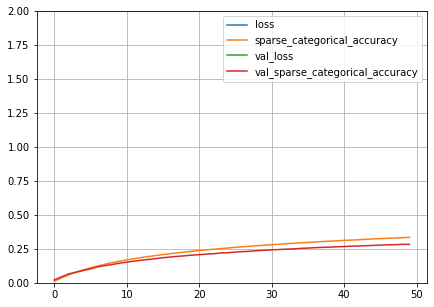

time: 260 ms (started: 2023-02-21 20:25:59 +00:00)


In [16]:
plot_loss(history)

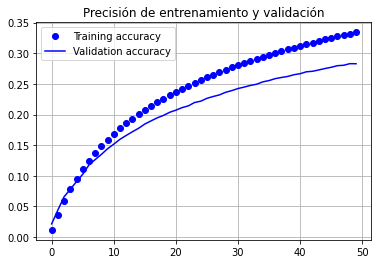

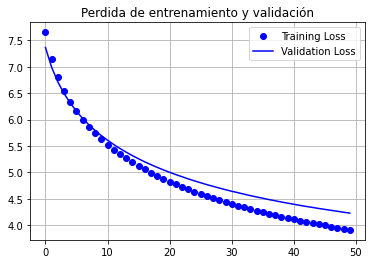

time: 406 ms (started: 2023-02-21 20:25:59 +00:00)


In [17]:
show_history(history)

In [18]:
save_model(SIZE, TFM_PATH, custom_model, TYPE_IMG, USE_DATA_AUG, DNN_NAME)

------ Model Saved in /content/gdrive/MyDrive/Master_IA/TFM/notebooks/arqs_2023/ResNet50/weights_resnet50/sin_DA/inverted/model_resnet50_etl9_imgs64_inverted__OTSU.h5
time: 1.91 s (started: 2023-02-21 20:25:59 +00:00)


# Imgs 96x96

- Test Accuracy: 0.3990724980831146
- Test Loss: 3.6874241828918457
- time: 2h 26min 44s
- F1 score: 0.3938925001256913
- Precision score: 0.4544786590861813
- Recall:  0.39907251264755483
- Epoch: 50/50


## Cargar las imágenes

In [19]:
SIZE = 96  # integer number. Ex: 64, 96, 112 or 127
WIDTH_SHAPE = SIZE
HEIGHT_SHAPE = SIZE
PATH = ROOT_PATH.format(SIZE)

time: 686 µs (started: 2023-02-21 20:26:01 +00:00)


In [20]:
train_images, train_labels, val_images, val_labels = load_images_for_training(DATA_REPR, PATH, TYPE_IMG)

time: 17.7 s (started: 2023-02-21 20:26:01 +00:00)


In [21]:
print('- train images:', train_images.shape, 'and labels:', train_labels.shape)
print()
print('- val images:', val_images.shape, 'and labels:', val_labels.shape)
print()

- train images: (444750, 96, 96, 1) and labels: (444750,)

- val images: (88950, 96, 96, 1) and labels: (88950,)

time: 5.63 ms (started: 2023-02-21 20:26:19 +00:00)


## Preparar el modelo

In [22]:
custom_model = create_custom_model(NUM_CLASSES, WIDTH_SHAPE, HEIGHT_SHAPE, CHANNEL)

time: 1.66 s (started: 2023-02-21 20:26:19 +00:00)


In [23]:
print(custom_model.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 96, 96, 1)]  0           []                               
                                                                                                  
 concatenate_1 (Concatenate)    (None, 96, 96, 3)    0           ['input_2[0][0]',                
                                                                  'input_2[0][0]',                
                                                                  'input_2[0][0]']                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 102, 102, 3)  0           ['concatenate_1[0][0]']          
                                                                                            

## Entrenar modelo

In [24]:
history = train_model(custom_model, train_images, train_labels, val_images, val_labels)

Epoch 1/50
13899/13899 [==============================] - 180s 13ms/step - loss: 7.7452 - sparse_categorical_accuracy: 0.0132 - val_loss: 7.5067 - val_sparse_categorical_accuracy: 0.0254
Epoch 2/50
13899/13899 [==============================] - 176s 13ms/step - loss: 7.3040 - sparse_categorical_accuracy: 0.0423 - val_loss: 7.1480 - val_sparse_categorical_accuracy: 0.0522
Epoch 3/50
13899/13899 [==============================] - 175s 13ms/step - loss: 6.9673 - sparse_categorical_accuracy: 0.0722 - val_loss: 6.8567 - val_sparse_categorical_accuracy: 0.0769
Epoch 4/50
13899/13899 [==============================] - 176s 13ms/step - loss: 6.6889 - sparse_categorical_accuracy: 0.1018 - val_loss: 6.6118 - val_sparse_categorical_accuracy: 0.1011
Epoch 5/50
13899/13899 [==============================] - 176s 13ms/step - loss: 6.4502 - sparse_categorical_accuracy: 0.1272 - val_loss: 6.4026 - val_sparse_categorical_accuracy: 0.1184
Epoch 6/50
13899/13899 [==============================] - 176s 13

In [25]:
test_images, test_labels = load_test_images(DATA_REPR, PATH, TYPE_IMG)

time: 2.45 s (started: 2023-02-21 22:53:06 +00:00)


In [26]:
show_metrics(custom_model, test_images, test_labels)

1854/1854 [==============================] - 18s 9ms/step
*********************************************************************************************************************************

- Test Accuracy: 0.3990724980831146
- Test Loss: 3.6874241828918457
- time: 
- F1 score: 0.3938925001256913
- Precision score: 0.4544786590861813
- Recall:  0.39907251264755483
- Epoch: 
*********************************************************************************************************************************
time: 40.3 s (started: 2023-02-21 22:53:09 +00:00)


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Graficando

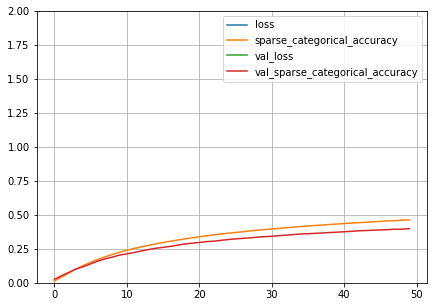

time: 206 ms (started: 2023-02-21 22:53:49 +00:00)


In [27]:
plot_loss(history)

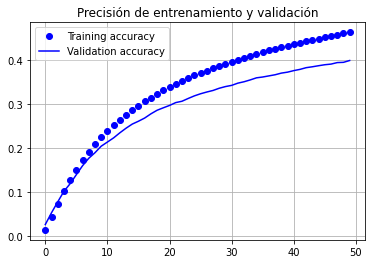

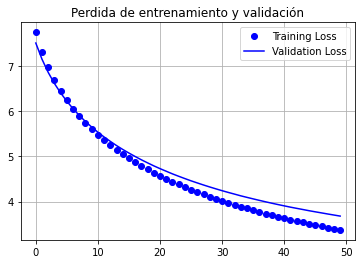

time: 349 ms (started: 2023-02-21 22:53:49 +00:00)


In [28]:
show_history(history)

In [29]:
save_model(SIZE, TFM_PATH, custom_model, TYPE_IMG, USE_DATA_AUG, DNN_NAME)

------ Model Saved in /content/gdrive/MyDrive/Master_IA/TFM/notebooks/arqs_2023/ResNet50/weights_resnet50/sin_DA/inverted/model_resnet50_etl9_imgs96_inverted__OTSU.h5
time: 773 ms (started: 2023-02-21 22:53:49 +00:00)


# Imgs 112x112

- Test Accuracy: 0.5717031955718994
- Test Loss: 2.3021721839904785
- time: 2h 30min 49s
- F1 score: 0.5716596360825064
- Precision score: 0.6081786380554637
- Recall:  0.5717032040472175
- Epoch: 50/50




## Cargar imágenes

In [30]:
SIZE = 112  # integer number. Ex: 64, 96, 112 or 127
WIDTH_SHAPE = SIZE
HEIGHT_SHAPE = SIZE
PATH = ROOT_PATH.format(SIZE)

time: 515 µs (started: 2023-02-21 22:53:51 +00:00)


In [31]:
train_images, train_labels, val_images, val_labels = load_images_for_training(DATA_REPR, PATH, TYPE_IMG)

time: 21.3 s (started: 2023-02-21 22:53:51 +00:00)


In [32]:
print('- train images:', train_images.shape, 'and labels:', train_labels.shape)
print()
print('- val images:', val_images.shape, 'and labels:', val_labels.shape)
print()

- train images: (444750, 112, 112, 1) and labels: (444750,)

- val images: (88950, 112, 112, 1) and labels: (88950,)

time: 984 µs (started: 2023-02-21 22:54:12 +00:00)


## Preparar el modelo

In [33]:
custom_model = create_custom_model(NUM_CLASSES, WIDTH_SHAPE, HEIGHT_SHAPE, CHANNEL)

time: 1.7 s (started: 2023-02-21 22:54:12 +00:00)


In [34]:
print(custom_model.summary())

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 112, 112, 1  0           []                               
                                )]                                                                
                                                                                                  
 concatenate_2 (Concatenate)    (None, 112, 112, 3)  0           ['input_3[0][0]',                
                                                                  'input_3[0][0]',                
                                                                  'input_3[0][0]']                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 118, 118, 3)  0           ['concatenate_2[0][0]']    

## Entrenar modelo


In [35]:
history = train_model(custom_model, train_images, train_labels, val_images, val_labels)

Epoch 1/50
13899/13899 [==============================] - 188s 13ms/step - loss: 7.2682 - sparse_categorical_accuracy: 0.0241 - val_loss: 6.7707 - val_sparse_categorical_accuracy: 0.0513
Epoch 2/50
13899/13899 [==============================] - 180s 13ms/step - loss: 6.4135 - sparse_categorical_accuracy: 0.0858 - val_loss: 6.1735 - val_sparse_categorical_accuracy: 0.1093
Epoch 3/50
13899/13899 [==============================] - 180s 13ms/step - loss: 5.8792 - sparse_categorical_accuracy: 0.1435 - val_loss: 5.7449 - val_sparse_categorical_accuracy: 0.1522
Epoch 4/50
13899/13899 [==============================] - 180s 13ms/step - loss: 5.4731 - sparse_categorical_accuracy: 0.1913 - val_loss: 5.4050 - val_sparse_categorical_accuracy: 0.1901
Epoch 5/50
13899/13899 [==============================] - 181s 13ms/step - loss: 5.1426 - sparse_categorical_accuracy: 0.2315 - val_loss: 5.1229 - val_sparse_categorical_accuracy: 0.2257
Epoch 6/50
13899/13899 [==============================] - 180s 13

In [36]:
test_images, test_labels = load_test_images(DATA_REPR, PATH, TYPE_IMG)

time: 2.99 s (started: 2023-02-22 01:25:04 +00:00)


In [37]:
show_metrics(custom_model, test_images, test_labels)

1854/1854 [==============================] - 22s 11ms/step
*********************************************************************************************************************************

- Test Accuracy: 0.5717031955718994
- Test Loss: 2.3021721839904785
- time: 
- F1 score: 0.5716596360825064
- Precision score: 0.6081786380554637
- Recall:  0.5717032040472175
- Epoch: 
*********************************************************************************************************************************
time: 49.1 s (started: 2023-02-22 01:25:07 +00:00)


## Graficando

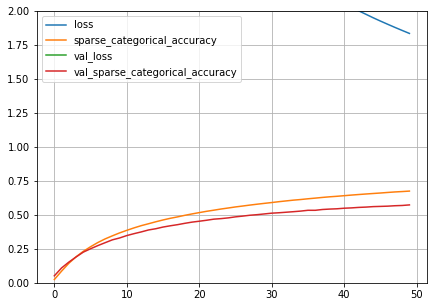

time: 219 ms (started: 2023-02-22 01:25:56 +00:00)


In [38]:
plot_loss(history)

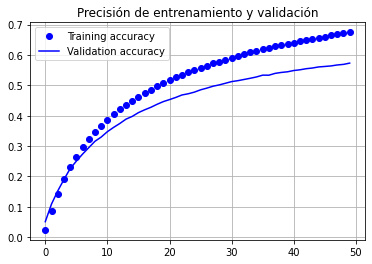

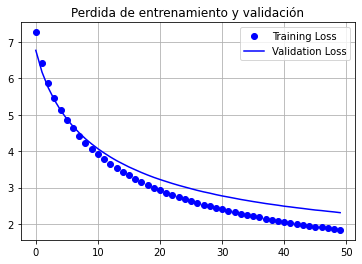

time: 1.08 s (started: 2023-02-22 01:25:57 +00:00)


In [39]:
show_history(history)

In [40]:
save_model(SIZE, TFM_PATH, custom_model, TYPE_IMG, USE_DATA_AUG, DNN_NAME)

------ Model Saved in /content/gdrive/MyDrive/Master_IA/TFM/notebooks/arqs_2023/ResNet50/weights_resnet50/sin_DA/inverted/model_resnet50_etl9_imgs112_inverted__OTSU.h5
time: 833 ms (started: 2023-02-22 01:25:58 +00:00)


In [43]:
quit()

time: 463 µs (started: 2023-02-22 01:26:14 +00:00)


# Imgs 127x127

- Test Accuracy: 0.4516526162624359
- Test Loss: 3.5699636936187744
- time: 2h 39min 52s
- F1 score: 0.4472331648305086
- Precision score: 0.5218912647300059
- Recall:  0.45165261382799327
- Epoch: 50/50



## Cargar imágenes

In [8]:
SIZE = 127  # integer number. Ex: 64, 96, 112 or 127
WIDTH_SHAPE = SIZE
HEIGHT_SHAPE = SIZE
PATH = ROOT_PATH.format(SIZE)

print(PATH)

/content/gdrive/MyDrive/Master_IA/TFM/datasets/etl_9G/uint32/imgs_127/splits/inverted_otsu/
time: 930 µs (started: 2023-02-22 01:28:26 +00:00)


In [9]:
train_images, train_labels, val_images, val_labels = load_images_for_training(DATA_REPR, PATH, TYPE_IMG)

time: 25.9 s (started: 2023-02-22 01:28:26 +00:00)


In [10]:
print('- train images:', train_images.shape, 'and labels:', train_labels.shape)
print()
print('- val images:', val_images.shape, 'and labels:', val_labels.shape)
print()

- train images: (444750, 127, 127, 1) and labels: (444750,)

- val images: (88950, 127, 127, 1) and labels: (88950,)

time: 1.51 ms (started: 2023-02-22 01:28:52 +00:00)


## Preparar el modelo

In [11]:
custom_model = create_custom_model(NUM_CLASSES, WIDTH_SHAPE, HEIGHT_SHAPE, CHANNEL)

time: 3.69 s (started: 2023-02-22 01:28:52 +00:00)


In [12]:
print(custom_model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 127, 127, 1  0           []                               
                                )]                                                                
                                                                                                  
 concatenate (Concatenate)      (None, 127, 127, 3)  0           ['input_1[0][0]',                
                                                                  'input_1[0][0]',                
                                                                  'input_1[0][0]']                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 133, 133, 3)  0           ['concatenate[0][0]']        

## Entrenar modelo

In [13]:
history = train_model(custom_model, train_images, train_labels, val_images, val_labels)

Epoch 1/50
13899/13899 [==============================] - 220s 15ms/step - loss: 7.7934 - sparse_categorical_accuracy: 0.0101 - val_loss: 7.5856 - val_sparse_categorical_accuracy: 0.0219
Epoch 2/50
13899/13899 [==============================] - 207s 15ms/step - loss: 7.4075 - sparse_categorical_accuracy: 0.0384 - val_loss: 7.2630 - val_sparse_categorical_accuracy: 0.0495
Epoch 3/50
13899/13899 [==============================] - 208s 15ms/step - loss: 7.1024 - sparse_categorical_accuracy: 0.0708 - val_loss: 6.9947 - val_sparse_categorical_accuracy: 0.0771
Epoch 4/50
13899/13899 [==============================] - 212s 15ms/step - loss: 6.8428 - sparse_categorical_accuracy: 0.1033 - val_loss: 6.7606 - val_sparse_categorical_accuracy: 0.1057
Epoch 5/50
13899/13899 [==============================] - 212s 15ms/step - loss: 6.6157 - sparse_categorical_accuracy: 0.1336 - val_loss: 6.5577 - val_sparse_categorical_accuracy: 0.1318
Epoch 6/50
13899/13899 [==============================] - 212s 15

## Graficando

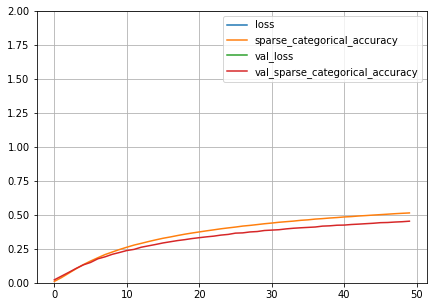

time: 241 ms (started: 2023-02-22 04:08:48 +00:00)


In [14]:
plot_loss(history)

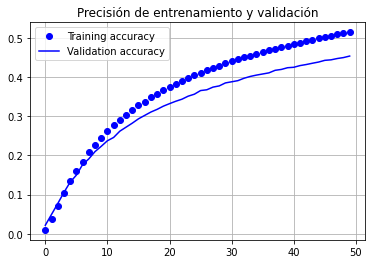

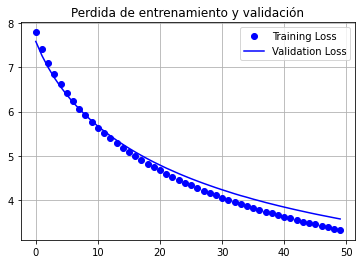

time: 388 ms (started: 2023-02-22 04:08:49 +00:00)


In [15]:
show_history(history)

In [16]:
save_model(SIZE, TFM_PATH, custom_model, TYPE_IMG, USE_DATA_AUG, DNN_NAME)

------ Model Saved in /content/gdrive/MyDrive/Master_IA/TFM/notebooks/arqs_2023/ResNet50/weights_resnet50/sin_DA/inverted/model_resnet50_etl9_imgs127_inverted__OTSU.h5
time: 780 ms (started: 2023-02-22 04:08:49 +00:00)


## Métricas

In [17]:
test_images, test_labels = load_test_images(DATA_REPR, PATH, TYPE_IMG)

time: 3.95 s (started: 2023-02-22 04:08:50 +00:00)


In [18]:
show_metrics(custom_model, test_images, test_labels)

1854/1854 [==============================] - 17s 9ms/step
*********************************************************************************************************************************

- Test Accuracy: 0.4516526162624359
- Test Loss: 3.5699636936187744
- time: 
- F1 score: 0.4472331648305086
- Precision score: 0.5218912647300059
- Recall:  0.45165261382799327
- Epoch: 
*********************************************************************************************************************************
time: 41.2 s (started: 2023-02-22 04:08:54 +00:00)


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
runtime.unassign()